Вы – единственный аналитик в компании, на которого легла ответственность за поиск инсайтов в данных продуктовых магазинов вашей компании. На повестке 3 задачи

In [1]:
import pandas as pd

import numpy as np 

from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from fbprophet import Prophet
import pandahouse as ph

# Задача 1

Воспользуйтесь данными и выясните, какие пары товаров пользователи чаще всего покупают вместе. То есть Вам необходимо найти паттерны покупок, что позволит оптимизировать размещение продуктов в магазине, для удобства пользователей и увеличения выручки. <br>
<br>
Поместить значения в таблицу со следующими колонками:<br>
**1_Товар** – наименование первого товара<br>
**2_Товар** – наименование второго товара<br>
**Встречаемость** – число раз, когда такая пара была встречена<br>
<br>
Напишите код на python для получения нужной таблицы и укажите 5 наиболее распространённых паттернов.

In [2]:
products = pd.read_csv('https://stepik.org/media/attachments/lesson/409319/test1_completed.csv')

products = products.rename(columns={"Товар": "product", "Количество": "quantity"})

list_products = products['product'].to_list() # создаём список со всеми покупками

set_products = set(list_products) # создём tuple, чтобы избавиться от повторений

cleared_list_products = list(set_products) # возвращаем формат списка 

list_combinations = list(combinations(cleared_list_products, 2)) # находим все возможные комбинации

agg_products = products.groupby('id')['product'].agg(list).to_frame().reset_index() 
# создаем аггрегированную таблицу, где покупки идут списками

list_checks = list(agg_products['product']) # создаём список списков со всеми чеками

list_lists_combinations = []
for comb in list_combinations:
    list_lists_combinations.append(list(comb))
# возвращаем формат списка списков

for comb in list_lists_combinations:
    comb.append(0)
# к каждой комбинации добавляем счётчик

for check in list_checks:  
    for comb in list_lists_combinations:
        if comb[0] in check and comb[1] in check:
            comb[2] += 1


first_five = sorted(list_lists_combinations, key=lambda i: i[2], reverse=True)[0:5] # сортируем по убыванию и выбираем первые 5

answer_1 = pd.DataFrame(first_five, columns = ['1_Товар','2_Товар','Встречаемость'], index=[1,2,3,4,5]) 
# переводим в табличный формат и делаем индекс более business friendly

answer_1

,1_Товар,2_Товар,Встречаемость
1,Укроп,Огурцы Луховицкие,431
2,Укроп,Петрушка,408
3,Арбуз,Огурцы Луховицкие,345
4,Огурцы Луховицкие,Кабачки,326
5,Укроп,Кинза,303


# Задача 2

Поступила информация о числе заказов за прошедшие 3 месяца с разрешением по неделям. Постройте (если это возможно) прогноз продаж на следующие 3 месяца, с учётом того, что в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция, повысившая число заказов на 7%

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


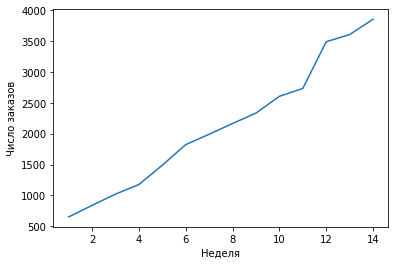

In [3]:
sales = pd.read_csv('https://stepik.org/media/attachments/lesson/426638/test2_completed.csv')

sales['Дата'] = pd.to_datetime(sales['Дата'])

sales['Неделя'] = sales['Дата'].dt.week

sns.lineplot(x='Неделя', y='Число заказов', data=sales)

C первого взгляда, кажется, что у заказов в магазине наблюдается сезонность, однако, мы предполагаем, что магазин недавно открыл услугу доставки товаров на дом. Также мы видим скачок в марте 2020 года, что наводит о мысли, что он произошёл благодаря объявленным карантинным мерам в городах России. <br>
Находясь в моменте, мы не знаем, как долго карантин может продолжаться. Исходя из этого определяется вес последних 3х недель. <br>
В случае продолжения карантина, им следует присвоить бОльший вес, в случае снятия ограничений - меньший. <br>
Тем не менее, стоит отметить, что прогноз на 3 месяца вперёд, имея данные только за 3 месяца не может быть достаточно достоверным, так как нет возможности выявить сезонность. <br>

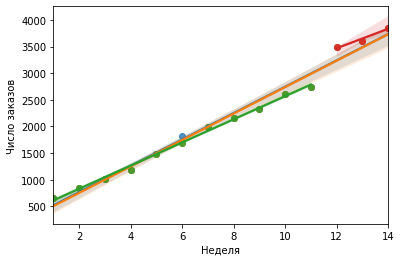

In [4]:
sns.regplot(x='Неделя', y='Число заказов', data = sales)

sales_2 = sales

sales_2.loc[5, 'Число заказов'] = sales_2.loc[5, 'Число заказов'] * 0.93 # мы убираем эффект от проведённой акции

sns.regplot(x='Неделя', y='Число заказов', data = sales_2)

sales_before = sales_2[:11]

sns.regplot(x='Неделя', y='Число заказов', data = sales_before)
sales_after = sales_2[11:]
sns.regplot(x='Неделя', y='Число заказов', data = sales_after)

In [5]:
sales_2.pop('Неделя')

sales_fb = sales_2.rename(columns={'Неделя': 'ds', 'Число заказов':'y'}) 

sales_fb['Дата'] = pd.to_datetime(sales_fb['Дата'])

sales_fb = sales_fb.rename(columns={'Дата': 'ds'})
# готовим данные для Prophet

In [6]:
sales_fb

,ds,y
0,2020-01-05,650.00
1,2020-01-12,837.00
2,2020-01-19,1020.00
3,2020-01-26,1176.00
4,2020-02-02,1489.00
5,2020-02-09,1695.39
6,2020-02-16,1991.00
7,2020-02-23,2166.00
8,2020-03-01,2334.00
9,2020-03-08,2607.00


В первом случае мы задаем параметры, полагая, что карантинные ограничения лишь временное явление, и последние данных не столь важны для нашего прогноза

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.


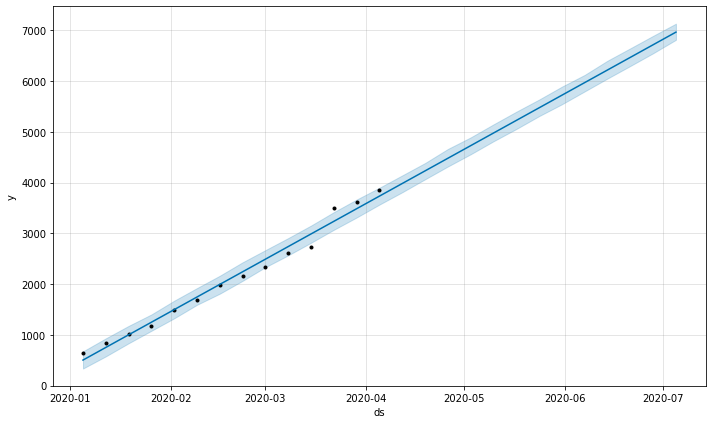

In [7]:
prophet = Prophet(changepoint_prior_scale=0.05, changepoint_range=0.1)
prophet.fit(sales_fb)
future = prophet.make_future_dataframe(periods=13, freq='W')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)

In [8]:
sales_mean = forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']]

answer_2_mean = sales_mean.rename(columns={'yhat':'Предсказанное значение',
                                           'yhat_lower':'Нижняя граница',
                                           'yhat_upper':'Верхняя граница', 
                                           'ds':'Дата'})

answer_2_mean = answer_2_mean[['Дата','Предсказанное значение','Нижняя граница','Верхняя граница']]\
                            .loc[14:].reset_index(drop=True)
answer_2_mean

,Дата,Предсказанное значение,Нижняя граница,Верхняя граница
0,2020-04-12,3981.001336,3808.568603,4140.716550
1,2020-04-19,4229.359873,4063.421430,4384.043994
2,2020-04-26,4477.718410,4315.599618,4660.987366
3,2020-05-03,4726.076947,4556.074515,4888.817707
4,2020-05-10,4974.435484,4812.034053,5145.031613
5,2020-05-17,5222.794021,5053.306855,5394.591745
6,2020-05-24,5471.152557,5307.315370,5634.011453
7,2020-05-31,5719.511094,5540.737474,5888.021839
8,2020-06-07,5967.869631,5794.369241,6119.461959
9,2020-06-14,6216.228168,6047.690420,6399.328477


В следующем прогнозе мы устанавливаем неделю в середине марта как переломную точку, считая, что ввод карантинных мер может изменить тренд. Также мы устанавливаем гибкость предсказания на более высоком уровне, так как не можем еще установить, насколько сильно могут повляить ограничения на продажи. 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


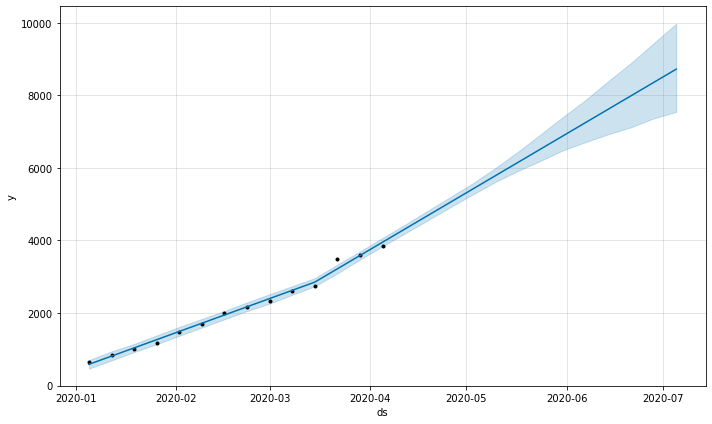

In [9]:
prophet_max = Prophet(changepoint_prior_scale=1, changepoints=['2020-03-15'])
prophet_max.fit(sales_fb)
future_max = prophet_max.make_future_dataframe(periods=13, freq='W')
forecast_max = prophet_max.predict(future_max)
fig_max = prophet_max.plot(forecast_max)

In [10]:
sales_max = forecast_max[['ds','yhat', 'yhat_lower', 'yhat_upper']]

answer_2_max = sales_max.rename(columns={'yhat':'Предсказанное значение',
                                         'yhat_lower':'Нижняя граница',
                                         'yhat_upper':'Верхняя граница', 
                                         'ds':'Дата'})

answer_2_max = answer_2_max[['Дата', 'Предсказанное значение','Нижняя граница','Верхняя граница']]\
                            .loc[14:].reset_index(drop=True)

answer_2_max

,Дата,Предсказанное значение,Нижняя граница,Верхняя граница
0,2020-04-12,4320.202799,4197.953284,4439.715303
1,2020-04-19,4687.272494,4556.005681,4822.226447
2,2020-04-26,5054.342189,4918.261924,5199.814733
3,2020-05-03,5421.411885,5271.999943,5581.493076
4,2020-05-10,5788.481580,5615.922585,6001.815837
5,2020-05-17,6155.551276,5918.554275,6450.394734
6,2020-05-24,6522.620971,6198.792601,6929.567521
7,2020-05-31,6889.690666,6489.208479,7412.443320
8,2020-06-07,7256.760362,6715.426102,7881.886533
9,2020-06-14,7623.830057,6931.113903,8398.572966


# Задача 3

В базе данных вашей компании присутствуют следующие таблицы <br>
 <br>
 **city** <br>
    city_id – id города, где проходит акция <br>
    client_city_id – id города, где находится покупатель <br>
    city – город  <br>
    client_city – город, где находится покупатель <br>
 **client** <br>
    client_id – id покупателя <br>
    client_city_id – id города, где находится покупатель <br>
    birth_date – дата рождения покупателя <br>
    registration – дата регистрации покупателя <br>
 **promotion** <br>
    promotion_id – id акции <br>
    category_id – id категории <br>
    promotion_name – акция <br>
    category_name – категория <br> 
    partner_id – id партнёра <br>
    partner_name – партнёр <br>
 **purchase** <br>
    purchase_id – id покупки <br>
    partner_id – id партнёра <br>
    client_id – id покупателя <br>
    city_id – id города <br>
    promotion_id – id акции <br>
    category_id – id категории <br>
    purchase_date – дата покупки <br>
    price – цена за единицу товара <br>
    quantity – число проданных единиц <br>
    status – статус покупки <br>
     <br>
Вам нужно написать запрос, чтобы получить такую таблицу <br>

   **purchase_date** – дата покупки <br>
   **purchase_id** – id покупки <br>
   **client_id** – id покупателя <br>
   **client_age** – возраст покупателя <br>
   **client_registration_age** – как долго человек пользуется вашими магазинами <br>
   **client_category** – содержит new или old, если это первая или последующая покупка соответственно <br>
   **promotion_name** – акция <br>
   **category_name** – категория <br>
   **partner_name** – партнёр <br>
   **client_city** – город, где находится покупатель <br>
   **city** – город <br>
   **revenue** – сумма выручки <br>
   **quantity** – число проданных единиц <br>

При этом в таблице должны присутствовать только значения, где в поле status стоит значение 1, и только те, где purchase_date находится в диапазоне от 01.05.2020 до 01.08.2020

# Комментарии

Колонку ***client_age*** мы решили реализовать выводом полных лет, так как только полная дата может повлиять на ассортимент предлагаемых клиенту товаров, а также помогает определить, с какого дня клиенту можно предоставить скидку в честь дня рождения. Также простое число проще использовать в дальнейнем для категоризации клиентов по возрасту.

Колонку ***client_registration_age*** мы решили реализовать через год и месяц со дня регистрации, так как полных лет регистрации у клиентов не так много. Возможно, магазин решит предоставить клиенту скидку раньше, чем наступит следующий полный год. Также значение поля можно выводить клиенту в приложении (если таковое имеется), чтобы он видел, как долго он пользуется сервисом магазина.

Колонка ***client_category*** реализована через аггрегацию уже совершенных покупок. Мы предполагаем, что таковыми считаются покупки, у которых status = 3 ("оплачено", как нам видится). При этом до тех пор, пока клиент не оплатил хотя бы одну покупку, его категория будет оставаться 'new', и только со следуюшего заказа будет отображаться 'old'.

Последние 2 колонки были приведены в формат Int32, чтобы pandahouse мог их прочитать. 

В задании не уточнялось, нужно ли включать в фильтрацию 1 августа 2020 года. Мы решили включить полные 3 месяца (1 квартал), то есть числа до 31 июля 2020 года включительно.

In [11]:
answer_3 = '''
SELECT 
    purchase_date, 
    purchase_id, 
    client_id, 
    client_age,
    client_registration_age,
    client_category, 
    promotion_name,
    category_name,
    partner_name,
    client_city, 
    city, 
    toInt32(revenue) as revenue, 
    toInt32(quantity) as quantity
FROM 
    (SELECT *
    FROM
        (SELECT DISTINCT(*) 
        FROM 
            (SELECT * 
            FROM 
                (SELECT city_id, city FROM project_variant_2.city) 
            AS cities_1
            JOIN
                (SELECT *
                FROM    
                    (SELECT 
                        purchase_date, 
                        purchase_id, 
                        client_id,
                        quantity,
                        price * quantity AS revenue,
                        status,
                        city_id,
                        promotion_id
                    FROM project_variant_2.purchase) 
                AS purchase_revenue
                JOIN 
                    (SELECT 
                        client_id, 
                        client_category, 
                        purchase_id 
                    FROM 
                        (SELECT * FROM project_variant_2.purchase) 
                        AS purchases_1
                        JOIN
                            (SELECT 
                                client_id,
                                purchase_id,
                                completed_purchases,
                                first_comleted_purchase,
                                purchase_date,
                                status,
                                CASE 
                                    WHEN if_completed = 'yes' and first_comleted_purchase < purchase_date 
                                    THEN 'old'
                                    ELSE 'new'
                                END AS client_category
                            FROM 
                                (SELECT * FROM project_variant_2.purchase) AS is_completed
                                LEFT JOIN
                                    (SELECT 
                                        client_id,
                                        Count(DISTINCT(purchase_id)) AS completed_purchases,
                                        min(purchase_date) as first_comleted_purchase,
                                        CASE 
                                            WHEN completed_purchases >= 1 
                                            THEN 'yes'
                                        END AS if_completed
                                    FROM project_variant_2.purchase
                                    WHERE status = 3 
                                    GROUP BY client_id) AS counter
                                ON is_completed.client_id = counter.client_id)
                        AS categories
                        ON purchases_1.purchase_id = categories.purchase_id)
                    AS purchase_category
                    ON 
                    purchase_revenue.purchase_id = purchase_category.purchase_id)                     
            AS agg_purchases
            ON cities_1.city_id = agg_purchases.city_id) 
            AS purchase_city
            JOIN 
                (SELECT * 
                FROM project_variant_2.promotion) AS promotions
            ON promotions.promotion_id = purchase_city.promotion_id) 
    AS l
    JOIN
        (SELECT *
        FROM 
            (SELECT DISTINCT(*) 
            FROM
                (SELECT 
                    client_city, 
                    client_city_id 
                FROM project_variant_2.city) AS cities_2
                JOIN 
                    (SELECT 
                        client_id, 
                        client_city_id, 
                        CASE
                            WHEN 
                                toDayOfMonth(today()) >= toDayOfMonth(registration)
                            THEN 
                                CONCAT(toString(intDiv(dateDiff(month, registration, today()) + 1, 12)), ' y ',
                                toString(modulo(dateDiff(month, registration, today()) + 1, 12)), ' m')
                            ELSE 
                                CONCAT(toString(intDiv(dateDiff(month, registration, today()), 12)), ' y ',
                                toString(modulo(dateDiff(month, registration, today()), 12)), ' m')
                        END AS client_registration_age,
                        CASE
                            WHEN 
                                toDayOfYear(today()) >= toDayOfYear(birth_date)
                            THEN 
                                dateDiff(year, birth_date, today())
                            ELSE 
                                dateDiff(year, birth_date, today()) - 1 
                        END AS client_age
                    FROM project_variant_2.client) AS clients
                ON cities_2.client_city_id = clients.client_city_id)) 
        AS r
        ON l.client_id = r.client_id)
HAVING 
    status = 1
    AND 
    purchase_date BETWEEN '2020-05-01' and '2020-07-31'
ORDER BY purchase_date
    '''